In [1]:
!pip install PyMySQL

     |████████████████████████████████| 43 kB 1.7 MB/s 


In [2]:
import pymysql

In [3]:
occupancy_db = pymysql.connect(
    user='datacollection', 
    passwd='collection2021!@', 
    host='121.156.90.144', 
    db='db_datacollection', 
    charset='utf8'
)

In [4]:
cursor = occupancy_db.cursor(pymysql.cursors.DictCursor)

In [5]:
sql = "Show Tables;"
cursor.execute(sql)
show = cursor.fetchall()
show

[{'Tables_in_db_datacollection': 'dc_building'},
 {'Tables_in_db_datacollection': 'dc_device'},
 {'Tables_in_db_datacollection': 'dc_floor'},
 {'Tables_in_db_datacollection': 'dc_long_term'},
 {'Tables_in_db_datacollection': 'dc_people_cnt'},
 {'Tables_in_db_datacollection': 'dc_pro_mode_define'},
 {'Tables_in_db_datacollection': 'dc_pro_module'},
 {'Tables_in_db_datacollection': 'dc_sensor'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_arduino_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_arduino_1_name'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_composite_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_temp_camera_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_temp_camera_info'},
 {'Tables_in_db_datacollection': 'dc_sensor_define'},
 {'Tables_in_db_datacollection': 'dc_server'},
 {'Tables_in_db_datacollection': 'dc_short_term'},
 {'Tables_in_db_datacollection': 'dc_spot'},
 {'Tables_in_db_datacollection': 'dc_unit_define'},
 {'Tables_in_db_datacollec

In [6]:
sql = "SELECT sdata_credate, sdata_temp FROM vw_data_composite WHERE sdata_modbus_id=1;"
cursor.execute(sql)
data = cursor.fetchall()

In [7]:
import pandas as pd

data = pd.DataFrame(data)

In [8]:
data.to_csv('occupancy_temp_20220120.csv')
# incom.to_csv('occupancyIO_20211117.csv')

In [9]:
import sys
print(sys.version)

3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]


In [10]:
composite_df = data
composite_df['sdata_credate'] = pd.to_datetime(composite_df['sdata_credate'])
composite_df.set_index('sdata_credate', inplace=True)
composite_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1753018 entries, 2021-05-25 14:13:29 to 2022-02-03 15:07:09
Data columns (total 1 columns):
 #   Column      Dtype  
---  ------      -----  
 0   sdata_temp  float64
dtypes: float64(1)
memory usage: 26.7 MB


In [11]:
composite_df=composite_df.loc['2021-10-07 00:00:00' :]

In [12]:
composite_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990199 entries, 2021-10-07 00:00:09 to 2022-02-03 15:07:09
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sdata_temp  990199 non-null  float64
dtypes: float64(1)
memory usage: 15.1 MB


In [13]:
composite_df.head()

,sdata_temp
sdata_credate,
2021-10-07 00:00:09,27.87
2021-10-07 00:00:19,27.89
2021-10-07 00:00:29,27.87
2021-10-07 00:00:39,27.87
2021-10-07 00:00:49,27.90


# 재실 데이터를 제외한 센서 데이터 그래프
- 온도, 습도, 이산화탄소 농도
- 온, 습도가 가장 관련성 높음
- 이산화탄소 농도와 온도도 관련성이 있음

In [14]:
composite_df = composite_df.resample('1T').first()
composite_df.fillna(composite_df.mean(),inplace=True)
composite_df.info()
composite_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172268 entries, 2021-10-07 00:00:00 to 2022-02-03 15:07:00
Freq: T
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sdata_temp  172268 non-null  float64
dtypes: float64(1)
memory usage: 2.6 MB


,sdata_temp
sdata_credate,
2021-10-07 00:00:00,27.87
2021-10-07 00:01:00,27.86
2021-10-07 00:02:00,27.89
2021-10-07 00:03:00,27.92
2021-10-07 00:04:00,27.89
...,...
2022-02-03 15:03:00,23.76
2022-02-03 15:04:00,23.80
2022-02-03 15:05:00,23.81


## 센서 데이터 1분 주기로 샘플링한 추세 그래프
- 온도

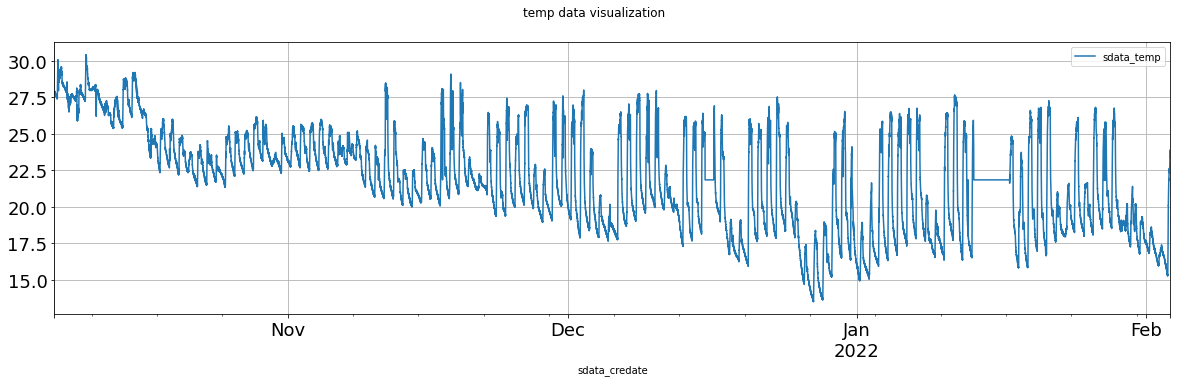

In [15]:
import matplotlib.pyplot as plt

composite_df.plot(subplots=True, grid=True, 
           figsize=(20, 5), fontsize=18,
           title='temp data visualization')
plt.show()

## 온도 데이터로 단변량 예측

In [16]:
from keras.models import load_model
import numpy as np

In [17]:
# 재실밀도 데이터
df = composite_df
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
temp_w1 = WindowGenerator(input_width=10080, label_width=1, shift=10080,
                         label_columns=['sdata_temp'])

In [20]:
temp_w2 = WindowGenerator(input_width=1440, label_width=1, shift=1,
                         label_columns=['sdata_temp'])

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
import tensorflow as tf

# Stack three slices, the length of the total window:
temp_window = tf.stack([np.array(train_df[:temp_w2.total_window_size]),
                           np.array(train_df[100:100+temp_w2.total_window_size]),
                           np.array(train_df[200:200+temp_w2.total_window_size])])

temp_inputs, temp_labels = temp_w2.split_window(temp_window)

print('Temperature shapes are: (batch, time, features)')
print(f'Window shape: {temp_window.shape}')
print(f'Inputs shape: {temp_inputs.shape}')
print(f'labels shape: {temp_labels.shape}\n')

Temperature shapes are: (batch, time, features)
Window shape: (3, 1441, 1)
Inputs shape: (3, 1440, 1)
labels shape: (3, 1, 1)



In [23]:
temp_w2.example = temp_inputs, temp_labels

In [24]:
# 온도
def temp_plot(self, model=None, plot_col='sdata_temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(20, 10))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [1m]')

WindowGenerator.temp_plot = temp_plot

In [25]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [26]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
temp_w2.train.element_spec

(TensorSpec(shape=(None, 1440, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

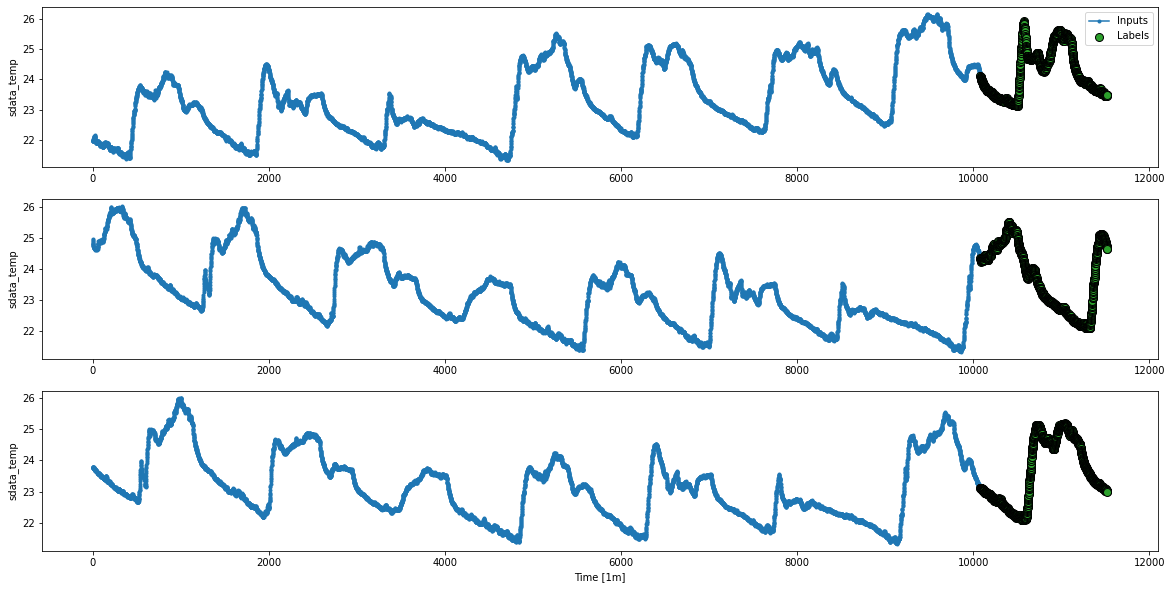

In [28]:
OUT_STEPS=1440
temp_multi_window = WindowGenerator(input_width=10080,
                                   label_width=OUT_STEPS,
                                   shift=OUT_STEPS)

temp_multi_window
temp_multi_window.temp_plot()

In [29]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### 온도

Epoch 1/100
3409/3409 [==============================] - 1346s 393ms/step - loss: 15.0115 - mean_absolute_error: 2.4540 - val_loss: 9.9859 - val_mean_absolute_error: 2.3828
Epoch 2/100
3409/3409 [==============================] - 1374s 403ms/step - loss: 3.8166 - mean_absolute_error: 1.4378 - val_loss: 7.2559 - val_mean_absolute_error: 2.0172
Epoch 3/100
3409/3409 [==============================] - 1348s 395ms/step - loss: 2.6300 - mean_absolute_error: 1.1753 - val_loss: 5.7018 - val_mean_absolute_error: 1.7839
Epoch 4/100
3409/3409 [==============================] - 1343s 394ms/step - loss: 1.6500 - mean_absolute_error: 0.9441 - val_loss: 7.1753 - val_mean_absolute_error: 2.1456
Epoch 5/100
717/717 [==============================] - 109s 152ms/step - loss: 6.6408 - mean_absolute_error: 1.9540


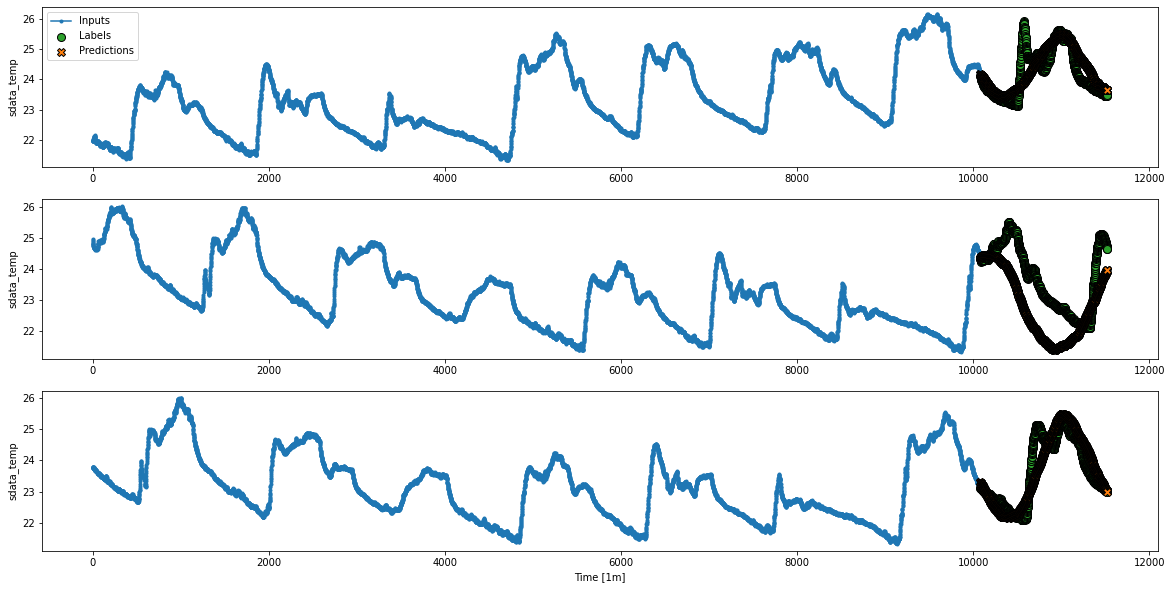

In [30]:
temp_multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

temp_history = compile_and_fit(temp_multi_lstm_model, temp_multi_window)

temp_multi_val_performance = {}
temp_multi_performance = {}
temp_multi_val_performance['LSTM'] = temp_multi_lstm_model.evaluate(temp_multi_window.val)
temp_multi_performance['LSTM'] = temp_multi_lstm_model.evaluate(temp_multi_window.test, verbose=0)

temp_multi_window.temp_plot(temp_multi_lstm_model)

In [31]:
temp_multi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1440)              185760    
                                                                 
 reshape (Reshape)           (None, 1440, 1)           0         
                                                                 
Total params: 252,320
Trainable params: 252,320
Non-trainable params: 0
_________________________________________________________________


In [32]:
temp_multi_lstm_model.evaluate(temp_multi_window.test)

179/179 [==============================] - 27s 153ms/step - loss: 6.9423 - mean_absolute_error: 2.0271


[6.94230842590332, 2.0270636081695557]

In [33]:
print('_________________________________________________________________')
print('Model evaluate')
print('=================================================================')
print('Loss: ', temp_multi_performance['LSTM'][0])
print('MAE(Mean Absolute Error): ', temp_multi_performance['LSTM'][1])
print('=================================================================')

_________________________________________________________________
Model evaluate
Loss:  6.942309379577637
MAE(Mean Absolute Error):  2.027064085006714


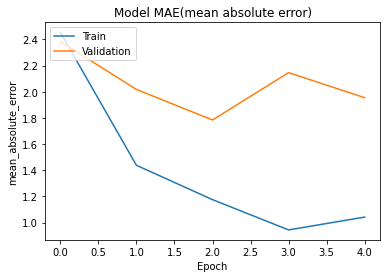

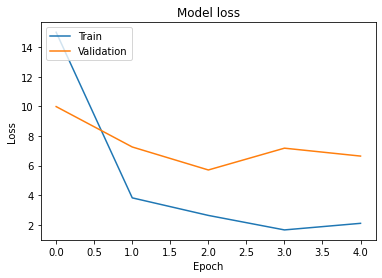

In [34]:
# 6 훈련 과정 시각화 (MAE)
plt.plot(temp_history.history['mean_absolute_error'])
plt.plot(temp_history.history['val_mean_absolute_error'])
plt.title('Model MAE(mean absolute error)')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(temp_history.history['loss'])
plt.plot(temp_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
temp_multi_lstm_model.save('temp_multi_lstm_model.h5')